# Time-series prediction with Keras `SimpleRNN` class
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---
### What is this Notebook about?
In this notebook, we show a building simple recurrent neural network (RNN) using Keras.

We will generate some synthetic time-series data by multiplying two periodic/ sinusoidal signals and adding some stochasticity (Gaussian noise). Then, we will take a small fraction of the data and train a simple RNN model with it and try to predict the rest of the data and see how the predictions match up with the ground truth.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [2]:
# Total time points
N = 3000
# Time point to partition train/test splits
Tp = 750  

t = np.arange(0,N)
x = (2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
len(df)

3000

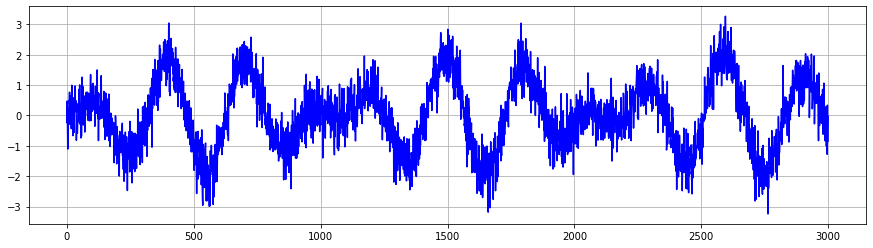

In [3]:
plt.figure(figsize=(15,4))
plt.plot(df, c='blue')
plt.grid(True)
plt.show()

### Split the values in train and test

So, we took only 25% of the data as training samples and set aside the rest of the data for testing. 

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

In [4]:
values = df.values
train, test = values[0:Tp ,:], values[Tp:N,:]

In [5]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (750, 1)
Test data length: (2250, 1)


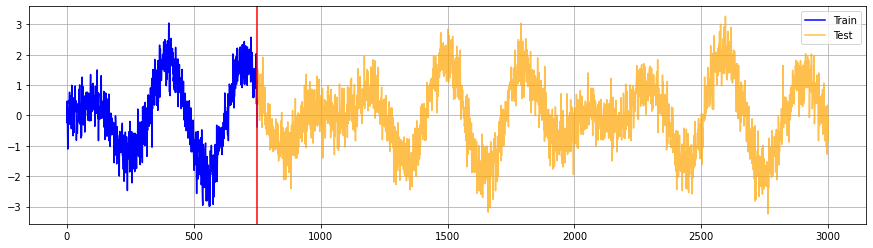

In [6]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp],train,c='blue')
plt.plot(index[Tp:N],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.show()

### Step (or _embedding_)
RNN model requires a step value that contains n number of elements as an input sequence.

Suppose x = {1,2,3,4,5,6,7,8,9,10}

for step=1, x input  and its y prediction become:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

Here, we choose `step=4`. In more complex RNN and in particular for text processing, this is also called _embedding size_.

In [8]:
train.shape

(750, 1)

In [9]:
step = 4
np.append(train,np.repeat(train[-1,],step)).shape

(754,)

In [10]:
train[-1,]

array([-0.37587501])

In [11]:
np.repeat(train[-1],10) 

array([-0.37587501, -0.37587501, -0.37587501, -0.37587501, -0.37587501,
       -0.37587501, -0.37587501, -0.37587501, -0.37587501, -0.37587501])

In [108]:
train[-8:]

array([[0.082365  ],
       [0.53597311],
       [0.70127677],
       [1.10355199],
       [0.93011688],
       [1.87697791],
       [1.42219381],
       [0.96968697]])

In [24]:
step = 4

# add step elements into train and test
test = np.append(test, np.repeat(test[-1,],step))
train = np.append(train, np.repeat(train[-1,],step))

In [25]:
train[-8:]

array([-0.37587501, -0.37587501, -0.37587501, -0.37587501, -0.37587501,
       -0.37587501, -0.37587501, -0.37587501])

In [26]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (758,)
Test data length: (2258,)


### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [27]:
def convert_to_matrix(data, step):
    X, Y = [], []
    for i in range(len(data)-step):
        d = i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [28]:
trainX, trainY = convert_to_matrix(train,step)
testX, testY = convert_to_matrix(test,step)

trainX.shape

(754, 4)

750 trozos de 4 valores

In [29]:
trainX[0]

array([-0.23346433,  0.47522996, -0.31125453, -1.10582415])

In [30]:
trainX[1]

array([ 0.47522996, -0.31125453, -1.10582415, -0.36828067])

In [31]:
trainX[2]

array([-0.31125453, -1.10582415, -0.36828067,  0.25377762])

In [32]:
trainX[3]

array([-1.10582415, -0.36828067,  0.25377762, -0.1667683 ])

In [22]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [23]:
trainX.shape

(750, 1, 4)

(9, 3, 1, 2, 1, 4)

### Ejemplo de dimensiones

In [33]:
[1,4,2,3]  --> (4,)

SyntaxError: invalid syntax (<ipython-input-33-82f371ae83f7>, line 1)

In [34]:
[[1,4,2,3], [1,4,2,3]] --> (2, 4)

SyntaxError: invalid syntax (<ipython-input-34-19b0e2bf614f>, line 1)

In [35]:
[[ [1,4,2,3], 
   [1,4,2,3]
]]  --> (1, 2, 4)

SyntaxError: invalid syntax (<ipython-input-35-b8db9890d6e0>, line 3)

In [36]:
[
   [
     [ 
       [1,4,2,3], 
       [1,4,2,3]
     ]
   ],
   [
     [ 
       [1,4,2,3], 
       [1,4,2,3]
     ]
   ]
]  

--> (2, 1, 2, 4)

SyntaxError: invalid syntax (<ipython-input-36-85d5fdbfa4ce>, line 16)

Para entrenar el modelo, necesito que los datos tengan la siguiente dimensión:

(750, 1, 4)

- 750: el número total de trozos 
- 1: una fila de datos
- 4: cada trozo tiene cuatro valores

En el caso de una imagen, recordemos con un ejemplo: 

(750, 28, 28)

750 imágenes de resolución 28x28

In [37]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (754, 4) ,  (754,)
Test data shape: (2254, 4) ,  (2254,)


### Keras model with `SimpleRNN` layer

- 256 neurons in the RNN layer
- 32 denurons in the densely connected layer
- a single neuron for the output layer
- ReLu activation
- learning rate: 0.001

In [38]:
def build_simple_rnn(num_units=128, embedding=4, num_dense=32, lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length - Steps - Tamaño de ventana
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(1, embedding), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(lr=lr),metrics=['mse'])
    
    return model

In [39]:
model = build_simple_rnn() # Taking the defaults


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               17024     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 21,185
Trainable params: 21,185
Non-trainable params: 0
_________________________________________________________________


### A simple callback class to show a message every 50 epochs

In [41]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Fit the model

Con batch_size = 16 lo que haríamos es que cogemos los datos de esta forma:

- (16, 1, 4)

Cogemos 16 trozos de 1 fila con 4 datos

In [42]:
batch_size=16
num_epochs = 1000

In [43]:
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[MyCallback()],verbose=0)

ValueError: in user code:

    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 4)


### Plot loss

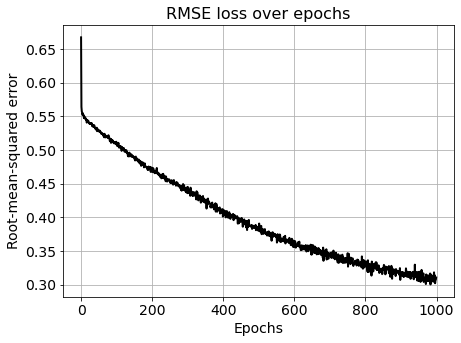

In [127]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data. 

In [44]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [45]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(testX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [46]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# predicted contiene todo el conjunto de datos predicho por nuestro modelo 
predicted = np.concatenate((trainPredict,testPredict),axis=0)

ValueError: in user code:

    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\RMOLLEDA\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 4)


In [47]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.grid(True)
plt.show()

NameError: name 'testPredict' is not defined

### Comparing it with the ground truth (test set)

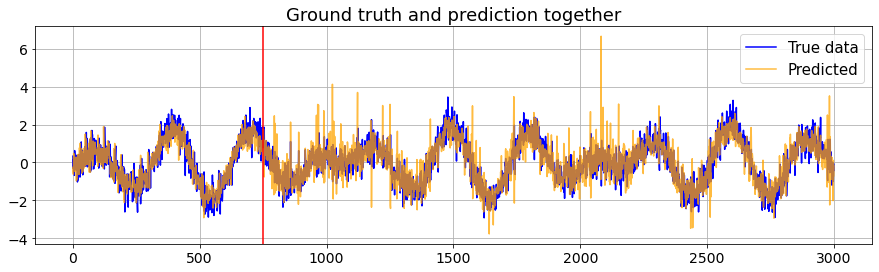

In [133]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index,df,c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How are the errors distributed?
The errors, or residuals, as they are called in a regression problem, can be plotted to see if they follow any specific distribution. In the generation process, we injected Gaussian noise, so we expect the error to follow the same pattern, _if the model has been able to fit to the real data correctly_.

In [134]:
error = predicted[Tp:N]-df[Tp:N]
error = np.array(error).ravel()

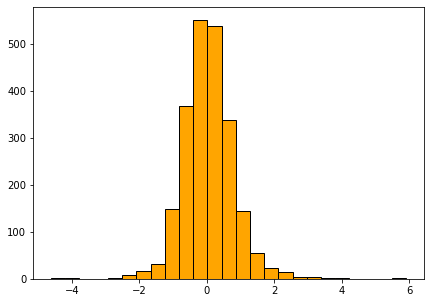

In [135]:
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange')
plt.show()

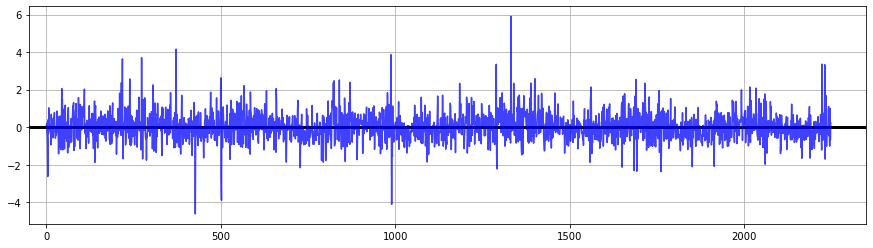

In [136]:
plt.figure(figsize=(15,4))
plt.plot(error,c='blue',alpha=0.75)
plt.hlines(y=0,xmin=-50,xmax=2400,color='k',lw=3)
plt.xlim(-50,2350)
plt.grid(True)
plt.show()

## Make the model better

Note, for running these experiments reasonably fast, we will fix the model size to be smaller than the model above. We will use a RNN layer with 32 neurons followed by a densely connected layer of 8 neurons.

### Varying the embedding/step size

In [137]:
def predictions(model,trainX,testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    predicted = np.concatenate((trainPredict,testPredict),axis=0)
    
    return predicted

In [138]:
def plot_compare(predicted):
    index = df.index.values
    plt.figure(figsize=(15,4))
    plt.title("Ground truth and prediction together",fontsize=18)
    plt.plot(index,df,c='blue')
    plt.plot(index,predicted,c='orange',alpha=0.75)
    plt.legend(['True data','Predicted'],fontsize=15)
    plt.axvline(df.index[Tp], c="r")
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [139]:
def prepare_data(step=4):
    values = df.values
    train, test = values[0:Tp,:], values[Tp:N,:]
    test = np.append(test,np.repeat(test[-1,],step))
    train = np.append(train,np.repeat(train[-1,],step))
    trainX, trainY =convertToMatrix(train,step)
    testX, testY =convertToMatrix(test,step)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    return trainX,testX,trainY,testY

In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def errors(testX, df):
    y_true = df[Tp:N].values
    y_pred = model.predict(testX)
    error = y_pred - y_true
    return [mean_absolute_error(y_true=y_true, y_pred=y_pred)]

Embedding size: 2
Error (mae): [0.31845651011161463]
----------------------------------------------------------------------------------------------------


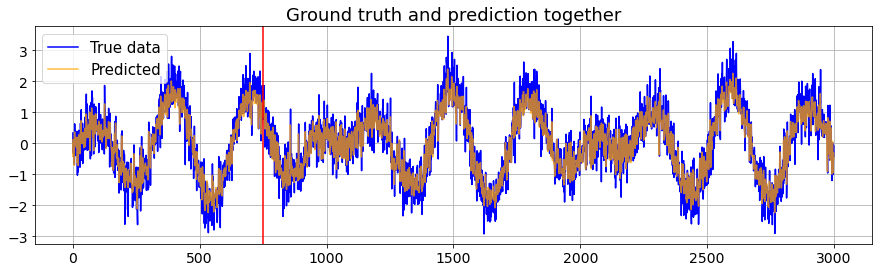


Embedding size: 4
Error (mae): [0.36456933256127105]
----------------------------------------------------------------------------------------------------


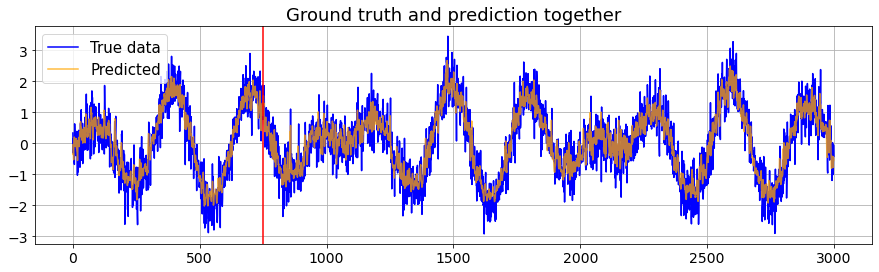


Embedding size: 6
Error (mae): [0.380927715084355]
----------------------------------------------------------------------------------------------------


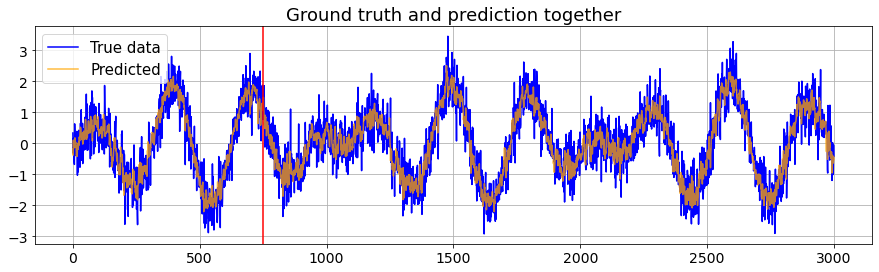


Embedding size: 8
Error (mae): [0.3995356308717703]
----------------------------------------------------------------------------------------------------


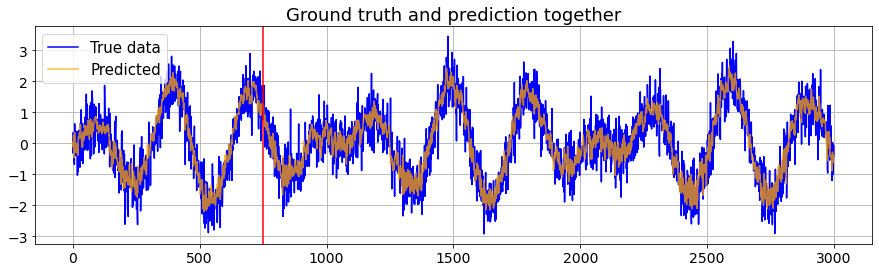


Embedding size: 10
Error (mae): [0.4299210795685163]
----------------------------------------------------------------------------------------------------


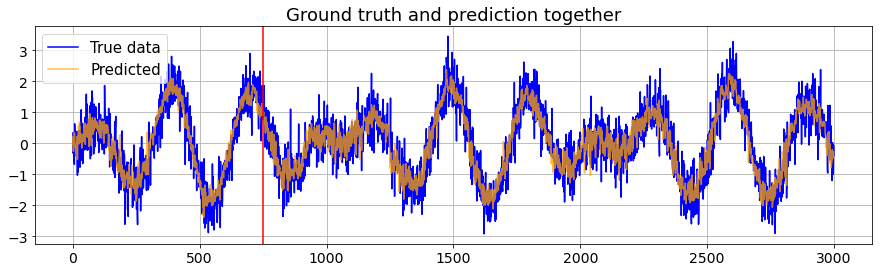


Embedding size: 12
Error (mae): [0.4551175977039113]
----------------------------------------------------------------------------------------------------


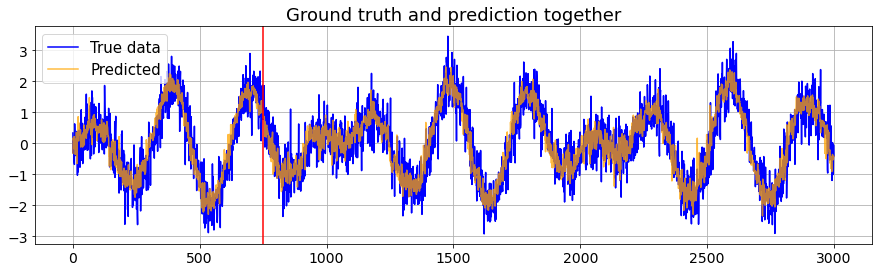

In [141]:
for s in [2,4,6,8,10,12]:  # s = steps  - tamaño ventana
    trainX,testX,trainY,testY = prepare_data(s)
    model = build_simple_rnn(num_units=32,num_dense=8, embedding=s)
    batch_size=16
    num_epochs = 100
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Embedding size: {}".format(s))
    print("Error (mae):", errors(testX, df))
    print("-"*100)
    plot_compare(preds)
    print()

### Number of epochs

Ran for 100 epochs
Error: [0.3145780707758662]
----------------------------------------------------------------------------------------------------


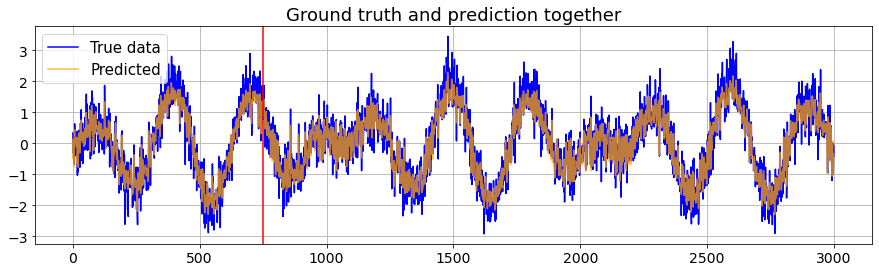


Ran for 200 epochs
Error: [0.3205453980720435]
----------------------------------------------------------------------------------------------------


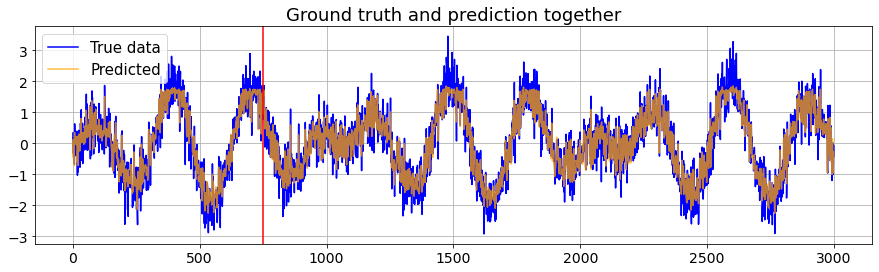


Ran for 300 epochs
Error: [0.32367804382197823]
----------------------------------------------------------------------------------------------------


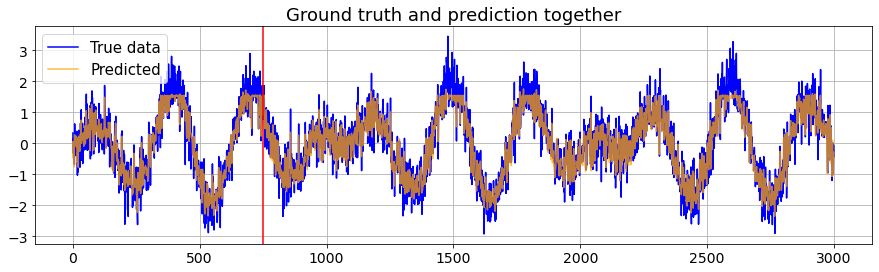


Ran for 400 epochs
Error: [0.3269139189620941]
----------------------------------------------------------------------------------------------------


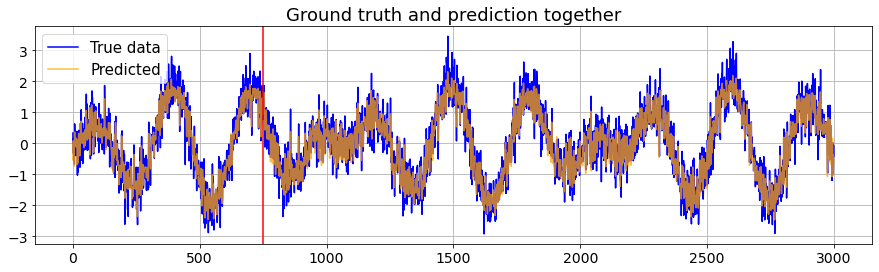


Ran for 500 epochs
Error: [0.3161765751872121]
----------------------------------------------------------------------------------------------------


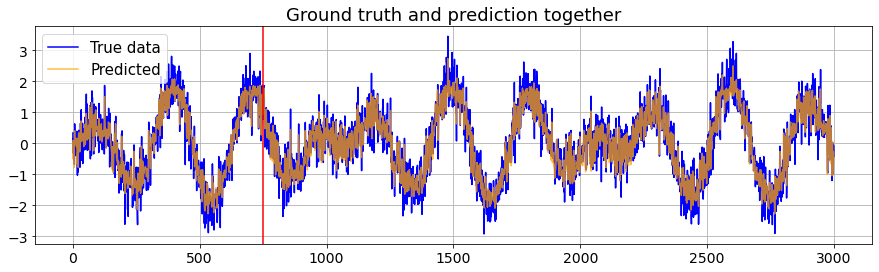

In [142]:
for e in [100,200,300,400,500]:
    trainX, testX, trainY, testY = prepare_data(2)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=2)
    batch_size=8
    num_epochs = e
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran for {} epochs".format(e))
    print("Error:", errors(testX, df))
    print("-"*100)
    plot_compare(preds)
    print()

### Batch size

Ran with batch size: 2
Error: [0.30584158804476186]
----------------------------------------------------------------------------------------------------


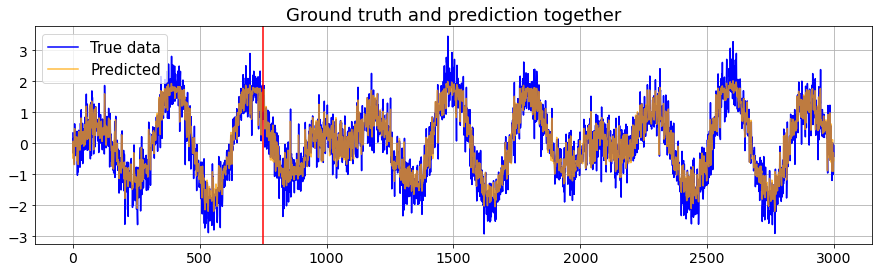


Ran with batch size: 4
Error: [0.3229301427069383]
----------------------------------------------------------------------------------------------------


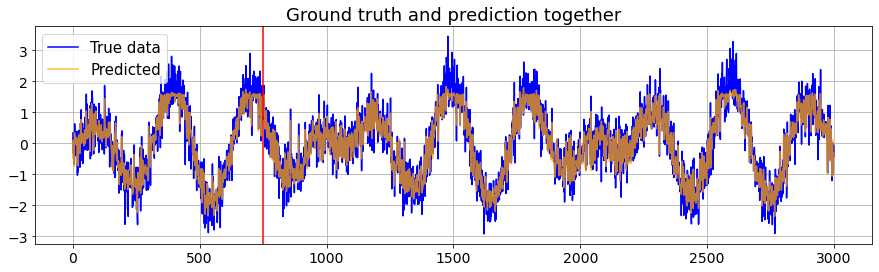


Ran with batch size: 8
Error: [0.3136971039750091]
----------------------------------------------------------------------------------------------------


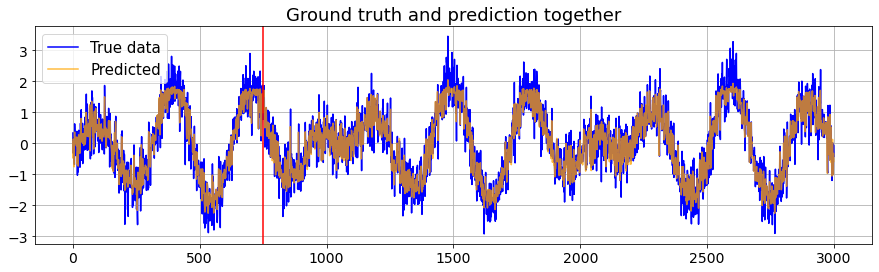


Ran with batch size: 16
Error: [0.31673044871898537]
----------------------------------------------------------------------------------------------------


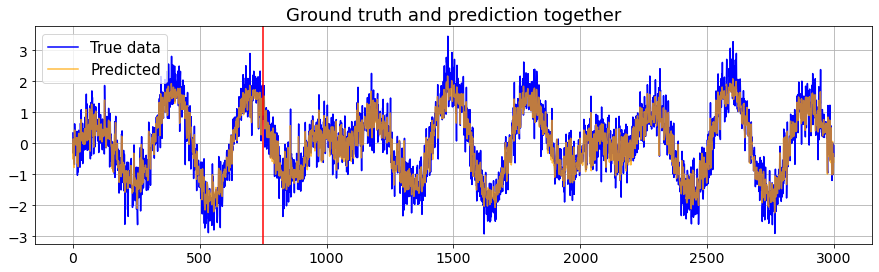


Ran with batch size: 32
Error: [0.3100050508983206]
----------------------------------------------------------------------------------------------------


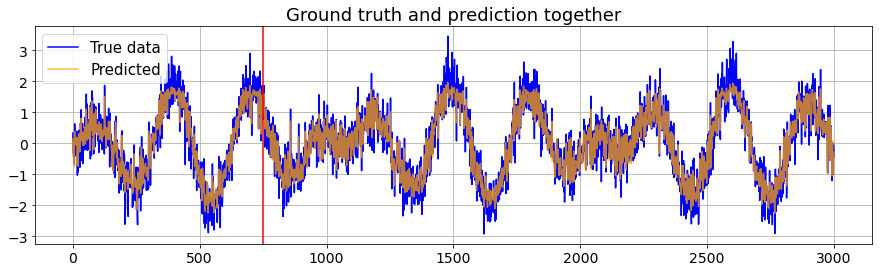


Ran with batch size: 64
Error: [0.3119204575578541]
----------------------------------------------------------------------------------------------------


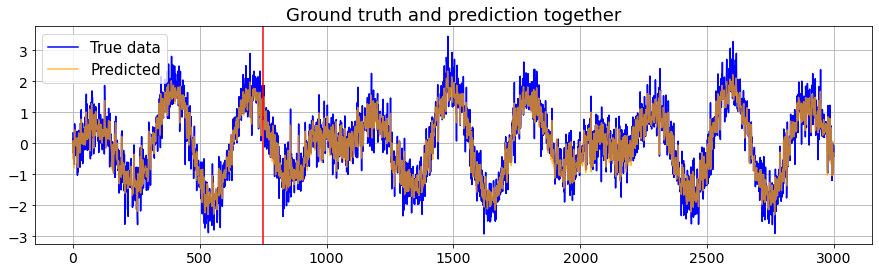

In [143]:
best_step = 2

for b in [2,4,8,16,32,64]:
    trainX,testX,trainY,testY = prepare_data(best_step)
    model = build_simple_rnn(num_units=32,num_dense=8,embedding=best_step)
    batch_size=b
    num_epochs = 250
    model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size,
          verbose=0)
    preds = predictions(model,trainX,testX)
    print("Ran with batch size: {}".format(b))
    print("Error:", errors(testX, df))
    print("-"*100)
    plot_compare(preds)
    print()

Ultimately, an exhaustive hyperparameter tuning is needed for the best overall performance. Also, the predictive power is not well-defined as we are judging the quality of the prediction mostly visually here but a neumerical metric (or a few of them) would be a better approach.